In [ ]:
'''
---------------------------------------------------------
Empirical calculation of Antigravitron Inequality Metrics 
---------------------------------------------------------
Rolando Gonzales Martinez
RUG & Oxford University
2025
---------------------------------------------------------
'''
import os
# Get current working directory
current_dir = os.getcwd()
print("Current directory:", current_dir)

import pandas as pd
# Load the uploaded dataset
df = pd.read_csv("income_ethnicity_by_region.csv")
# Display the first few rows and column names to understand structure
df.head(), df.columns.tolist()

Current directory: c:\2025\07_July\gravitron


(   year                       geography               ethnic_group  \
 0  2000                    DVRPC Region  Black or african american   
 1  2000           NJ Counties Subregion  Black or african american   
 2  2000  PA Suburban Counties Subregion  Black or african american   
 3  2000   Philadelphia County Subregion  Black or african american   
 4  2005                    DVRPC Region  Black or african american   
 
    median_income  income_gap_from_white  income_gap_from_white_percent  
 0        57836.0                44090.0                          0.433  
 1        75123.0                31643.0                          0.296  
 2        71429.0                40405.0                          0.361  
 3        48236.0                19974.0                          0.293  
 4        50480.0                50362.0                          0.499  ,
 ['year',
  'geography',
  'ethnic_group',
  'median_income',
  'income_gap_from_white',
  'income_gap_from_white_percent'])

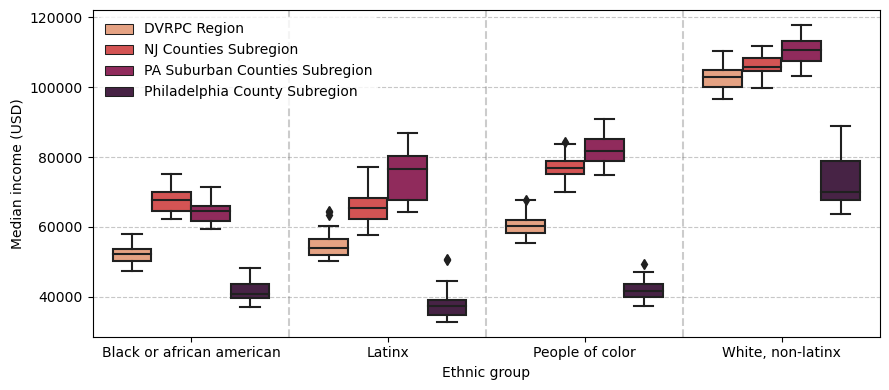

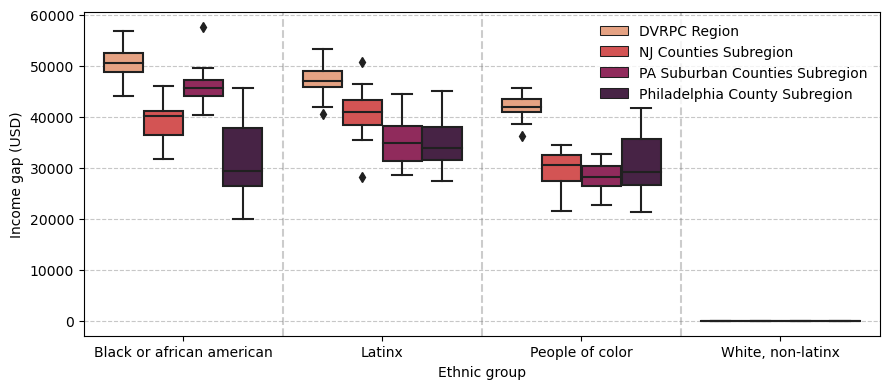

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Re-plot using the correct column names
plt.figure(figsize=(9, 4))

# Create the boxplot
ax = sns.boxplot(
    data=df,
    x="ethnic_group",
    y="median_income",
    hue="geography",
    palette="rocket_r"
    #palette="magma_r"
)

# Format x-axis labels to wrap text
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', wrap=True)

# Add gridlines
ax.set_axisbelow(True)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
# Get x-tick positions and add vertical lines between groups
xticks = ax.get_xticks()
for i in range(1, len(xticks)):
    ax.axvline(x=(xticks[i-1] + xticks[i]) / 2, color='gray', linestyle='--', alpha=0.4)

# Titles and labels
ax.set_xlabel("Ethnic group")
ax.set_ylabel("Median income (USD)")

# Remove box around legend
legend = ax.get_legend()
legend.set_title(None)
legend.get_frame().set_linewidth(0.0)

# Improve layout
plt.tight_layout()
plt.savefig("figbp_01.png", dpi=600)
plt.show()

plt.figure(figsize=(9, 4))

# Create the boxplot
ax = sns.boxplot(
    data=df,
    x="ethnic_group",
    y="income_gap_from_white",
    hue="geography",
    palette="rocket_r"
    #palette="magma_r"
)

# Format x-axis labels to wrap text
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', wrap=True)

# Add gridlines
ax.set_axisbelow(True)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
# Get x-tick positions and add vertical lines between groups
xticks = ax.get_xticks()
for i in range(1, len(xticks)):
    ax.axvline(x=(xticks[i-1] + xticks[i]) / 2, color='gray', linestyle='--', alpha=0.4)

# Titles and labels
ax.set_xlabel("Ethnic group")
ax.set_ylabel("Income gap (USD)")

# Remove box around legend
legend = ax.get_legend()
#legend = ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
legend.set_title(None)
legend.get_frame().set_linewidth(0.0)

# Improve layout
plt.tight_layout()
plt.savefig("figbp_02.png", dpi=600)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import beta as beta_dist, entropy
from scipy.cluster.vq import kmeans2
from scipy.spatial.distance import cdist

# Load your dataset
df = pd.read_csv("income_ethnicity_by_region.csv")

# Exclude white groups (e.g., "White", "White, non-latinx", etc.)
df = df[~df['ethnic_group'].str.lower().str.contains('white')]

# Normalize 'income_gap_from_white' and 'median_income' to [0, 1]
scaler = MinMaxScaler()
df[['gap_norm', 'income_norm']] = scaler.fit_transform(df[['income_gap_from_white', 'median_income']])
df[['gap_norm', 'income_norm']] = df[['gap_norm', 'income_norm']].clip(1e-3, 1 - 1e-3)

# Drop rows with NaNs introduced by normalization
df = df.dropna(subset=['gap_norm', 'income_norm'])

# Function to compute Beta mixture inequality metric
def compute_beta_mixture_inequality(group_df):
    group_df = group_df.dropna(subset=['gap_norm', 'income_norm'])  # Drop NaNs within group
    samples = group_df[['gap_norm', 'income_norm']].values
    if samples.shape[0] < 3:
        return np.nan

    weights = np.ones(samples.shape[0])
    M = 2  # number of clusters

    try:
        centroids, labels = kmeans2(samples, M, minit='points')
    except:
        return np.nan

    pi = np.array([weights[labels == m].sum() / weights.sum() for m in range(M)])
    alpha_params = []
    beta_params = []

    for m in range(M):
        cluster_points = samples[labels == m]
        a_params, b_params = [], []
        for dim in range(2):
            x = cluster_points[:, dim]
            mean = np.clip(x.mean(), 1e-3, 1 - 1e-3)
            var = max(x.var(), 1e-6)
            tmp = mean * (1 - mean) / var - 1
            a_params.append(mean * tmp)
            b_params.append((1 - mean) * tmp)
        alpha_params.append(a_params)
        beta_params.append(b_params)

    alpha_params = np.array(alpha_params)
    beta_params = np.array(beta_params)

    modal_entropy = entropy(pi)
    concentration = 0
    for m in range(M):
        x = beta_dist.rvs(alpha_params[m, 0], beta_params[m, 0], size=1000)
        y = beta_dist.rvs(alpha_params[m, 1], beta_params[m, 1], size=1000)
        hist2d, _, _ = np.histogram2d(x, y, bins=20, range=[[0, 1], [0, 1]], density=True)
        hist2d_flat = hist2d.flatten() + 1e-10
        ent = entropy(hist2d_flat)
        concentration += pi[m] * (1 / ent)

    mode_centers = np.array([
        [alpha_params[m, 0] / (alpha_params[m, 0] + beta_params[m, 0]),
         alpha_params[m, 1] / (alpha_params[m, 1] + beta_params[m, 1])]
        for m in range(M)
    ])
    pairwise_distances = cdist(mode_centers, mode_centers, metric='euclidean')
    weighted_dist = sum(pi[i] * pi[j] * pairwise_distances[i, j]
                        for i in range(M) for j in range(i + 1, M))

    return modal_entropy * concentration * weighted_dist

# Compute inequality by geography and ethnic group
inequality_results = df.groupby(['geography', 'ethnic_group']).apply(compute_beta_mixture_inequality).reset_index()
inequality_results.columns = ["geography", "ethnic_group", "inequality_metric"]
inequality_results = inequality_results.sort_values(by=["geography", "inequality_metric"], ascending=[True, False])

inequality_results.to_csv("inequality_results.csv", index=False)

inequality_results

,geography,ethnic_group,inequality_metric
2,DVRPC Region,People of color,6.078664e-02
1,DVRPC Region,Latinx,5.320178e-02
0,DVRPC Region,Black or african american,4.951165e-02
4,NJ Counties Subregion,Latinx,1.966897e+06
3,NJ Counties Subregion,Black or african american,1.428599e+06
5,NJ Counties Subregion,People of color,1.069142e-01
7,PA Suburban Counties Subregion,Latinx,2.265250e+06
8,PA Suburban Counties Subregion,People of color,1.459338e+06
6,PA Suburban Counties Subregion,Black or african american,1.437830e+06
11,Philadelphia County Subregion,People of color,2.271642e+06
